# Denoising autoencoder -- MLP implementation

### Download data

In [3]:
!wget -O SVHN.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat # download SVHN dataset
!mkdir datasets # create dataset dir
!mv SVHN.mat datasets # move SVHN data to dataset dir

--2020-05-15 21:13:09--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘SVHN.mat’

SVHN.mat            100%[===================>] 173.61M  53.9MB/s    in 4.4s    

2020-05-15 21:13:13 (39.5 MB/s) - ‘SVHN.mat’ saved [182040794/182040794]



### Imports

In [0]:
import numpy as np # numpy for matrix operations
import math # math for mathematical operations
import scipy.io # scipy for loading data

# keras layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ReLU
from keras.losses import MSE
from keras import regularizers

### Read images

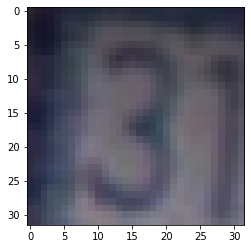

In [13]:
images = np.rollaxis(np.array(scipy.io.loadmat("datasets/SVHN.mat")['X']), axis = 3, start=0) #read and reshape images
plt.imshow(images[8]) # show sample image

### Create noisy images

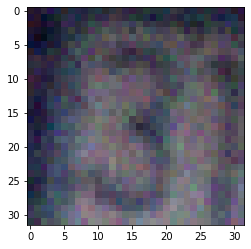

In [14]:
noise = np.random.binomial(400, 0.5, images.shape)-200 # generate gaussian noise
noisy_images = images + noise # add noise to data
plt.imshow(noisy_images[8]) # show sample noisy image

### Add salt/pepper noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


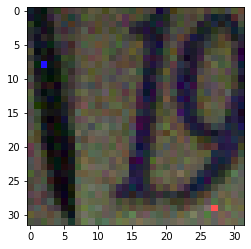

In [15]:
mask = np.random.randint(0,1000,size=noisy_images.shape).astype(np.bool) # generate pepper noise
noisy_images *= mask # add pepper noise

noisy_images = 255-noisy_images # invert image

mask = np.random.randint(0,1000,size=noisy_images.shape).astype(np.bool) # repeat for salt noise
noisy_images *= mask

noisy_images = 255-noisy_images # invert again

plt.imshow(noisy_images[0]) # show image

### Split dataset

In [0]:
split = math.floor(0.9*len(images)) # split dataset to train and val

val_images = images[split:]
val_noisy_images = noisy_images[split:]

images = images[:split]
noisy_images = noisy_images[:split]

### Normalize data

In [0]:
avg = np.average(noisy_images) # calculate mean
std = np.std(noisy_images) # calculate std

noisy_images_downscaled  = (noisy_images - avg) / std # normalize data (standard norm.)
val_noisy_images_downscaled = (val_noisy_images - avg) / std

### Define model

In [0]:
class Autoencoder():
   
    def __init__(self, levels, layers, thickness, n):
        super(Autoencoder, self).__init__()
        self.levels = levels
        self.layers = layers
        self.n = n
        self.thickness = thickness
        self.__built = False

    def __build(self, X):
        self.__model = Sequential()
        self.__model.add(Flatten())
        for level in range(self.levels):
            for layer in range(self.layers):
                if level == 0 and layer == 0:
                    self.__model.add(Dense(2**(8-level), input_shape=X.shape[1:4], name=f"encoder_dense{level}_{layer}", kernel_regularizer=regularizers.l2(1e-6), bias_regularizer=regularizers.l2(1e-6)))
                else:
                    self.__model.add(Dense(2**(8-level), name=f"encoder_dense{level}_{layer}"))
        for level in reversed(range(self.levels)):
            for layer in range(self.layers):
                self.__model.add(Dense(2**(8-level), name=f"decoder_dense{level}_{layer}", kernel_regularizer=regularizers.l2(1e-6), bias_regularizer=regularizers.l2(1e-6)))
        self.__model.add(Dense(32*32*3, name="final_dense"))
        self.__model.add(Reshape(target_shape=(32, 32, 3)))
        self.__model.compile(loss=['mse'], optimizer="adam")
        self.__built = True

    def forward(self, X, Y_target):
        if not self.__built:
            self.__build(X)
        loss = self.__model.train_on_batch(X, Y_target)
        return loss
    
    def summary(self):
        assert self.__built, "Build model first by passing a tensor to it."
        self.__model.summary()
    
    def predict(self, X):
        return self.__model.predict(X)

    def trainable(self, val):
        if not self.__built:
            self.__build(X)
        for layer in self.__model.layers:
            layer.trainable = val


### Train model
Results can be achieved in about 30 minutes.

In [19]:
model = Autoencoder(levels = 3, layers = 1, thickness = 2, n = 3) # create model
epochs = 200 #  number of epochs
batch_size = 12 # batch size for mini-batching
lr = 0.0000001 # learning rate


loss_history = []
val_loss_history = []

batches = math.ceil(images.shape[0] / batch_size) # calculate number of batches
val_batches = math.ceil(val_images.shape[0] / batch_size)

for e in range(epochs):
    loss_total = 0
    for b in range(batches): # pass all batches through the network
        # before forward step, create the input and target batches
        X = noisy_images_downscaled[batch_size*b:batch_size*(b+1)]
        Y_target = images[batch_size*b:batch_size*(b+1)]
        
        model.trainable(True) # enable training
        loss = model.forward(X, Y_target) # forward step

        loss_total += loss

    loss_avg = loss_total / (batches*batch_size) # calculate avg loss
    loss_history.append(loss_avg)
    print(f"epoch {e} -- loss: {loss_avg}", end="")

    val_loss_total = 0
    for b in range(val_batches): # repeat for the val dataset
        X = val_noisy_images_downscaled[batch_size*b:batch_size*(b+1)]
        Y_target = val_images[batch_size*b:batch_size*(b+1)]

        model.trainable(False)
        val_loss = model.forward(X, Y_target)

        val_loss_total += val_loss

    val_loss_avg = val_loss_total / (val_batches*batch_size)
    val_loss_history.append(val_loss_avg)
    print(f" -- val_loss: {val_loss_avg}")


epoch 0 -- loss: 136.23077816834478

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 -- val_loss: 25.2671391226461
epoch 1 -- loss: 32.516309047880625 -- val_loss: 20.504461682824832
epoch 2 -- loss: 21.03351596419219 -- val_loss: 16.05327359328033
epoch 3 -- loss: 17.069331601333502 -- val_loss: 14.50557237938331
epoch 4 -- loss: 15.397558980194916 -- val_loss: 13.707248088380904
epoch 5 -- loss: 14.474121370856459 -- val_loss: 13.302283851552778
epoch 6 -- loss: 13.598189610454362 -- val_loss: 12.857625705845942
epoch 7 -- loss: 13.08286421147845 -- val_loss: 12.582032457571243
epoch 8 -- loss: 12.637368132498976 -- val_loss: 12.380331882283262
epoch 9 -- loss: 12.259882108898355 -- val_loss: 12.052202715356039
epoch 10 -- loss: 12.169494433572229 -- val_loss: 11.833945884642157
epoch 11 -- loss: 12.066072612319312 -- val_loss: 12.090176751427617
epoch 12 -- loss: 11.98855420775872 -- val_loss: 11.547266121451736
epoch 13 -- loss: 11.966232868277885 -- val_loss: 11.4582347817845
epoch 14 -- loss: 11.917062346458724 -- val_loss: 11.41409824015466
epoch 15 -- loss: 11

KeyboardInterrupt: ignored

### Model summary

In [20]:
model.summary() # print model summary

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
encoder_dense0_0 (Dense)     (None, 256)               786688    
_________________________________________________________________
encoder_dense1_0 (Dense)     (None, 128)               32896     
_________________________________________________________________
encoder_dense2_0 (Dense)     (None, 64)                8256      
_________________________________________________________________
decoder_dense2_0 (Dense)     (None, 64)                4160      
_________________________________________________________________
decoder_dense1_0 (Dense)     (None, 128)               8320      
_________________________________________________________________
decoder_dense0_0 (Dense)     (None, 256)              

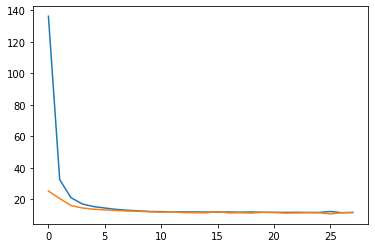

In [21]:
plt.plot(loss_history) # plot loss history
plt.plot(val_loss_history)

### Results

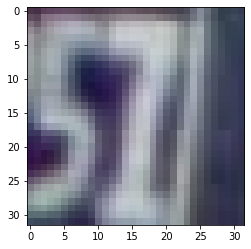

In [22]:
plt.imshow(val_images[8]) # sample image

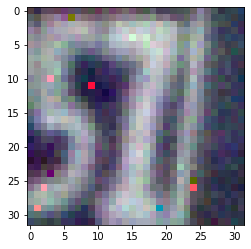

In [23]:
plt.imshow(val_noisy_images[8]) # sample noisy image

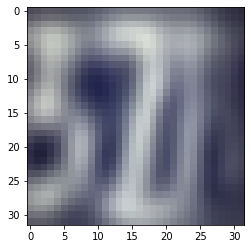

In [24]:
[pred] = model.predict(val_noisy_images_downscaled[8:9])
pred = np.array(np.rint(pred), dtype=int) # create denoised image
pred = np.where(pred > 255, 255, pred) # filter out too large values
pred = np.where(pred < 0, 0, pred) # filter out negative values
plt.imshow(pred) # show filtered image